<a href="https://colab.research.google.com/github/NicoAN42/SKRPSI/blob/main/cnn_skrp_b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
#mount dataset
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
import tensorflow
from tensorflow.keras.layers import Conv2D, Input, concatenate, Activation, InputLayer, Dense, Reshape, Flatten
from tensorflow.keras.layers import LeakyReLU,ReLU, MaxPooling2D, BatchNormalization,GlobalMaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras.activations import softmax,sigmoid
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout,SpatialDropout2D,GaussianDropout
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.regularizers import l1,l2
import math
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
import os
import random
import shutil

In [53]:
CLASS = 3
#sourcepath isi semua data train, folder valid kosongin datanya sisai folder classnya
sourcePath = '/content/drive/MyDrive/Colab Notebooks/Dataset 999'
train_path = '/content/drive/MyDrive/Colab Notebooks/Dataset 999/train'
valid_path = '/content/drive/MyDrive/Colab Notebooks/Dataset 999/valid'
test_path = '/content/drive/MyDrive/Colab Notebooks/Dataset 999/test'

#nico

In [54]:
classLabels =['covid','normal', 'pneumonia']

In [55]:
model = Sequential()

In [56]:
model.add(layers.InputLayer(input_shape=(256, 256, 3)))

In [57]:
input_Layer=model.add(layers.InputLayer(input_shape=(256, 256, 3)))

In [58]:
#Layer 1
model.add(layers.Conv2D(32, (3,3), padding='same', name='conv_1', activation = 'relu'))
model.add(layers.BatchNormalization(name='norm_1'))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides= 2))


In [59]:
#Layer 2
model.add(layers.Conv2D(64, (3,3), padding='same', name='conv_2', activation = 'relu')),
model.add(layers.Dropout(0.1))
model.add(layers.BatchNormalization(name='norm_2'))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides = 2))

In [60]:
# Layer 3
model.add(layers.Conv2D(64, (3,3), padding='same', name='conv_3', activation = 'relu'))
model.add(layers.BatchNormalization(name='norm_3'))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides = 2))


In [61]:
# Layer 4
model.add(layers.Conv2D(128, (3,3), padding='same', name='conv_4', activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization(name='norm_4'))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides = 2))


In [62]:
# Layer 5
model.add(layers.Conv2D(256, (3,3), padding='same', name='conv_5', activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization(name='norm_5'))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides = 2))


In [63]:
model.add(layers.Flatten())
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(3,Activation('softmax')))
model.output_shape

(None, 3)

In [64]:
output = model.output_shape

In [65]:
print(input_Layer)

None


In [66]:
#initial_learning_rate=0.0001

In [67]:
#lr_schedule = ExponentialDecay(
#   initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
#)


In [68]:
opt = Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

In [69]:
model.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"] )

In [70]:
print(model.summary())
print(model)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        multiple                  0         
                                                                 
 conv_1 (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 norm_1 (BatchNormalization)  (None, 256, 256, 32)     128       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 128, 128, 32)     0         
 g2D)                                                            
                                                                 
 conv_2 (Conv2D)             (None, 128, 128, 64)      18496     
                                                                 
 dropout_8 (Dropout)         (None, 128, 128, 64)      0         
                                                      

In [71]:
X = []
Y = []
def transferBetweenFolders(source, dest, splitRate): 
    global sourceFiles
    sourceFiles=os.listdir(source)
    if(len(sourceFiles)!=0):
        transferFileNumbers=int(len(sourceFiles)*splitRate)
        transferIndex=random.sample(range(0, len(sourceFiles)), transferFileNumbers)
        for eachIndex in transferIndex:
            shutil.move(source+str(sourceFiles[eachIndex]), dest+str(sourceFiles[eachIndex]))
    else:
        print("No file moved. Source empty!")
        

In [72]:
def transferAllClassBetweenFolders(source, dest, splitRate):
    for label in classLabels:
        transferBetweenFolders(sourcePath+'/'+source+'/'+label+'/', 
                               sourcePath+'/'+dest+'/'+label+'/', 
                               splitRate)
        

In [73]:
def prepareNameWithLabels(folderName):
    sourceFiles=os.listdir(sourcePath+'/train/'+folderName)
    for val in sourceFiles:
        X.append(val)
        for i in range(len(classLabels)):
          if(folderName==classLabels[i]):
              Y.append(i)
# Organize file names and class labels in X and Y variables
for i in range(len(classLabels)):
  prepareNameWithLabels(classLabels[i])

def my_metrics(y_true, y_pred):
    accuracy=accuracy_score(y_true, y_pred)
    precision=precision_score(y_true, y_pred,average='weighted')
    f1Score=f1_score(y_true, y_pred, average='weighted') 
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("f1Score : {}".format(f1Score))
    cm=confusion_matrix(y_true, y_pred)
    print(cm)
    return accuracy, precision, f1Score

In [74]:
X=np.asarray(X)
Y=np.asarray(Y)

print(X)
print(Y)

skf = StratifiedKFold(n_splits=5
                      , shuffle=True)
skf.get_n_splits(X, Y)
foldNum=0

['COVID(360).png' 'COVID(364).png' 'COVID(361).png' ...
 'person970_bacteria_2895.jpeg' 'person968_bacteria_2893.jpeg'
 'person998_bacteria_2928.jpeg']
[0 0 0 ... 2 2 2]


Results for fold 1
Found 1917 images belonging to 3 classes.
Found 378 images belonging to 3 classes.
Found 405 images belonging to 3 classes.
Epoch 1/20
30/30 - 839s - loss: 1.0824 - accuracy: 0.8644 - val_loss: 4.6839 - val_accuracy: 0.3466 - 839s/epoch - 28s/step
Epoch 2/20
30/30 - 24s - loss: 0.1463 - accuracy: 0.9478 - val_loss: 1.1389 - val_accuracy: 0.5952 - 24s/epoch - 804ms/step
Epoch 3/20
30/30 - 24s - loss: 0.0731 - accuracy: 0.9713 - val_loss: 0.5369 - val_accuracy: 0.8095 - 24s/epoch - 801ms/step
Epoch 4/20
30/30 - 24s - loss: 0.0664 - accuracy: 0.9797 - val_loss: 0.2237 - val_accuracy: 0.9259 - 24s/epoch - 807ms/step
Epoch 5/20
30/30 - 24s - loss: 0.0404 - accuracy: 0.9828 - val_loss: 0.3195 - val_accuracy: 0.8968 - 24s/epoch - 798ms/step
Epoch 6/20
30/30 - 24s - loss: 0.0371 - accuracy: 0.9885 - val_loss: 0.2192 - val_accuracy: 0.9418 - 24s/epoch - 800ms/step
Epoch 7/20
30/30 - 24s - loss: 0.0534 - accuracy: 0.9828 - val_loss: 0.2229 - val_accuracy: 0.9418 - 24s/epoch - 

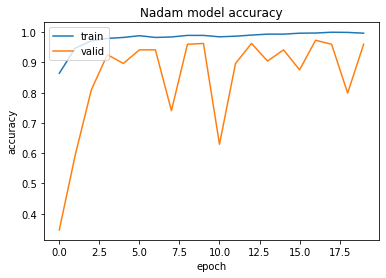

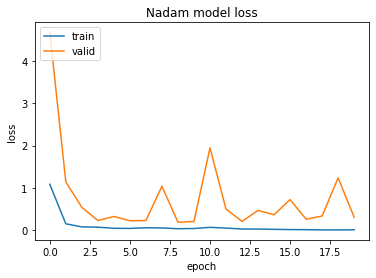

7/7 [==============================] - 4s 632ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 2 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 2 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 1
 2 1 2 2 2 2 1 2 2 1 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2
 2 2 2 2 2 2 1 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2]
***Performance on Validation data***
Accuracy  : 0.9481481481481482
Precision : 0.9503644866240286
f1Score : 0.94813095856492

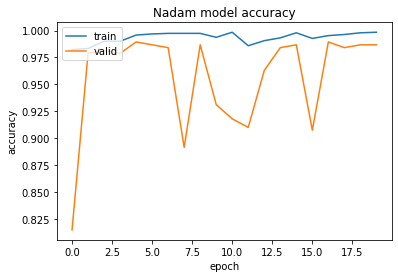

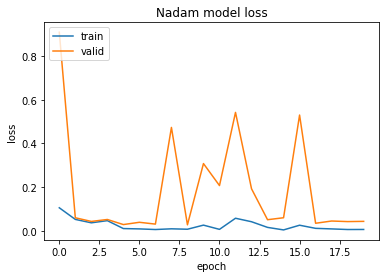

7/7 [==============================] - 4s 627ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 2 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 1
 2 1 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 0 2 1 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2]
***Performance on Validation data***
Accuracy  : 0.9555555555555556
Precision : 0.9556724929346945
f1Score : 0.95555306247199

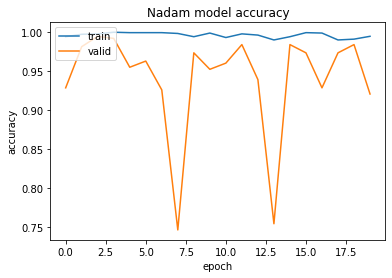

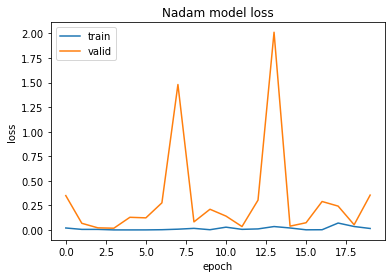

7/7 [==============================] - 4s 618ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 1 2 1 2 1 1 1 2 2 1 1 2
 1 1 2 1 2 2 1 1 1 2 1 2 2 2 1 1 1 1 2 2 1 1 1 1 2 1 1 1 1 1 1 1 1 1 2 1 1
 1 1 2 1 1 1 1 1 1 2 1 1 1 0 1 1 1 1 1 1 1 1 1 2 1 1 1 2 1 1 1 1 1 2 1 1 2
 1 1 2 2 1 2 1 1 2 1 2 1 1 1 1 1 2 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 2 1
 1 2 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 1
 2 1 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2
 2 2 2 2 0 2 1 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2]
***Performance on Validation data***
Accuracy  : 0.8888888888888888
Precision : 0.899213791796912
f1Score : 0.888342421962758

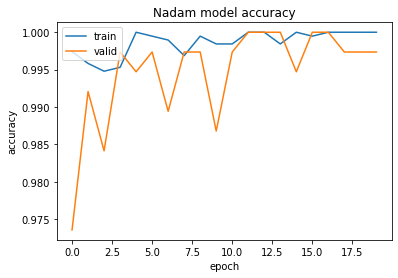

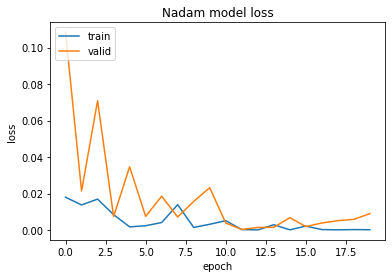

7/7 [==============================] - 4s 630ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 2 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 2 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 1
 2 1 2 2 2 2 2 2 2 2 1 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 0 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2]
***Performance on Validation data***
Accuracy  : 0.9555555555555556
Precision : 0.9555864128236082
f1Score : 0.95545866285979

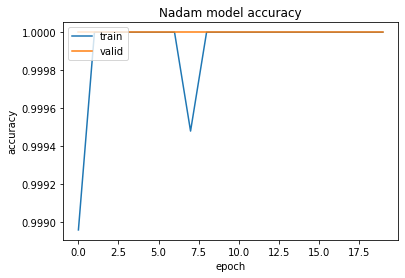

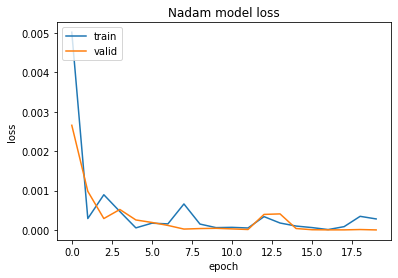

7/7 [==============================] - 4s 610ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 2 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 2 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 1
 2 1 2 2 2 2 1 2 2 2 1 2 2 0 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 0 2 1 2 0 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2]
***Performance on Validation data***
Accuracy  : 0.9481481481481482
Precision : 0.9488387567847552
f1Score : 0.94787063032930

In [75]:
for train_index, val_index in skf.split(X, Y):
    #First cut all images from validation to train (if any exists)
    transferAllClassBetweenFolders('valid', 'train', 1.0)
    foldNum+=1
    print("Results for fold",foldNum)
    X_train, X_val = X[train_index], X[val_index]
    Y_train, Y_val = Y[train_index], Y[val_index]
    # Move validation images of this fold from train folder to the validation folder
    for eachIndex in range(len(X_val)):
        classLabel=''
        for i in range(len(classLabels)):
          if(Y_val[eachIndex]==i):
              classLabel=classLabels[i]
        #Then, copy the validation images to the validation folder
        shutil.move(sourcePath+'/train/'+classLabel+'/'+X_val[eachIndex], 
                    sourcePath+'/valid/'+classLabel+'/'+X_val[eachIndex])
        
    train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(256,256), classes=['covid', 'normal', 'pneumonia'], class_mode = 'sparse', batch_size = 64, shuffle=True)
    valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size=(256,256), classes=['covid', 'normal', 'pneumonia'], class_mode = 'sparse', batch_size = 64, shuffle=True)
    test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(256,256), classes=['covid', 'normal', 'pneumonia'], class_mode = 'sparse', batch_size = 64, shuffle=False)

    history = model.fit(train_batches, 
                    validation_data=valid_batches,
                    epochs=20, 
                    verbose=2)
    
    model.evaluate(test_batches)
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Nadam model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Nadam model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()
    predictions = model.predict(test_batches, verbose=1)
    yPredictions = np.argmax(predictions, axis=1)
    print(yPredictions)
    true_classes = test_batches.classes
    # evaluate validation performance
    print("***Performance on Validation data***")    
    valAcc, valPrec, valFScore = my_metrics(true_classes, yPredictions)